# Rb87 Polarizability Calcs

The tensor polarizability function uses Mark's derived result for linear light (to be extended for other polarizations). The vector polarizability is from "Dynamical polarizability of atoms in arbitrary light fields: 
general theory and application to cesiu"  by Rauscenbeutel.

#### Rules to remember:
Scalar shift: no dependence on light polarization <br/>
Vector shift: zero for linear light or $j_a=0$ <br/>
Tensor shift: non-zero iff $j_a\geq1$ <br/>

In [1]:
# %matplotlib inline

#### libraries
from numpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from arc import *
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan

#### local files
import sys, os
sys.path.append('..\\')
sys.path.append('..\\utilities')
from physconsts import *
from rbconsts import *
from amophys import * # polarizability functions live here
from simfuncs import *

#### other
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
def smart_pts(func, domain, default_res=10, alpha=1, dx_test=None):
    """
    Get list of func and pts at which func is evaluated.
    
    Evaluates more points in region where func is changing rapidly than where
    the derivative is small, to avoid the need to use high resolution steps 
    over the whole domain.
    
    Args:
        func(x: float):->float
        domain: two element list-like of floats [xmin, xmax]
        default_res: the number of points to use when the derivative is near zero
        alpha: a tuning parameter. higher is better for sharply changing functions
    Return
        xpts,func_pts,: the points at which func was evaluated and func evaluated at those points
    """
    xmin,xmax = domain
    dx = (xmax-xmin)/default_res
    
    if dx_test == None:
        dx_test = dx/1000 # very small step to approximate derivative using next step

    x = xmin
    xpts = [x]
    func_pts = [func(x)] # can't use np array because don't know size in advance
    last_df = 0
    
    while x < xmax:
        
        df = abs((func(x+dx_test) - func(x))/(dx_test))
        # TODO: add in code to check if probe is small enough
        
        
        x += dx*exp(-alpha*df) # should go to dx when slope zero
        xpts.append(x)
        func_pts.append(func(x))
    
    return array(xpts),array(func_pts)

In [ ]:
x,f = smart_pts(lambda x: 1/(1+(100*x)**2),[-10,10],default_res=30,alpha=1)

In [ ]:
plt.scatter(x,f,linewidths=0.5)
plt.plot(x,f)
plt.show()

## todo: update this. 
the correct definitions for polarizabilities can be found in "Dynamical polarizability of atoms in arbitrary light fields: 
general theory and application to cesiu" by Rauschenbeutel. I use their definitions with some 
combination of the expressions as they are presented in Mark's notes."

## Dynamic polarizabilities for hyperfine states

#### Definitions - the expressions here are from Daniel Steck, and he admits that the vector, tensor expressions may be incorrect (they are). 

Below, the labels $F,F'$ refer to hyperfine levels $|n,L,J,F\rangle,|n',L',J',F'\rangle$, where the quantum numbers $I,S$ are the same between the two states and hence have been suppressed. Therefore the sums over F' are sums over such levels, rather than over just the quantum number F. 

The AC Stark shift on a level F is:

$U_{AC}(\omega) = -\alpha_F(\omega)\frac{|E|^2}{4}$

The total hyperfine polarizability, using scalar (S), vector (V), and tensor (T) polarizabilities which are decoupled from the projection $m_F$, is given by:

$\alpha_{F,m_F}(\omega) = \alpha_F^{(S)}(\omega) + \hat{k}\cdot\hat{B}A\frac{A m_F}{2F}\alpha_F^{(V)}(\omega) + \left(3|\hat{\eta}\cdot \hat{B}|^2-1\right)\frac{3m_F^2-F(F+1)}{2F(2F-1)}\alpha_F^{(T)}(\omega)$

where $\hat{B}$ is the quantization axis unit vector, $\hat{\eta}$ is the laser polarization unit vector, $A=0,\pm1$ corresponds to linear and right/left-handed light polarization, and the $m_F$-independent polarizabilities are

$\alpha_F^{(S)} = \sum_{F'}\frac{2\omega_{F,F'}|\langle F || \hat{d} || F'\rangle|^2}{3\hbar(\omega_{F',F}^2-\omega^2)}$

$\alpha_F^{(V)} = \sum_{F'}(-1)^{F+F'+1}\sqrt{\frac{6F(2F+1)}{F+1}}S_{F,F,F'}^{1,1,1}\frac{\omega_{F,F'}|\langle F || \hat{d} || F'\rangle|^2}{\hbar(\omega_{F',F}^2-\omega^2)}$

$\alpha_F^{(T)} = \sum_{F'}(-1)^{F+F'}\sqrt{\frac{40F(2F+1)(2F-1)}{3(F+1)(2F+3)}}S_{F,F,F'}^{1,1,2}\frac{\omega_{F,F'}|\langle F || \hat{d} || F'\rangle|^2}{\hbar(\omega_{F',F}^2-\omega^2)}$

Hyperfine reduced matrix element expressed in the fine-structure basis:

$\langle F || \hat{d} || F'\rangle = (-1)^{1+I+J+F'}\sqrt{(2F'+1)(2F+1)}S_{F1J}^{J'IF'}\langle J || \hat{d} || J'\rangle$

Depending on the convention used to evaluate the fine structure matrix element, it may need to be divided by $\sqrt{2J+1}$ to yield the correct result.  

#### Rules to remember:
Scalar shift: no dependence on light polarization <br/>
Vector shift: zero for linear light or $j_a=0$ <br/>
Tensor shift: non-zero for $j_a\geq1$ <br/>

## Tests
summarized from test notebook, with corrections/additions

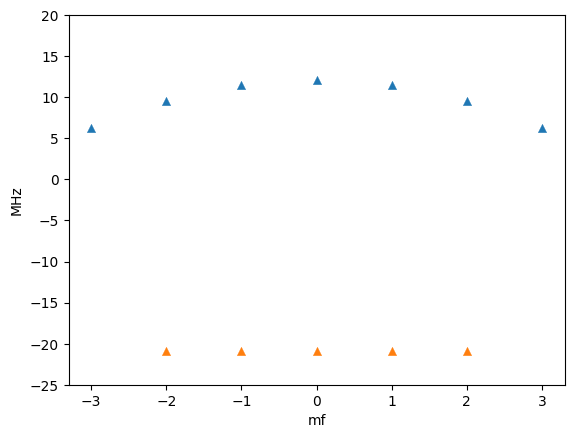

In [2]:
# reproduce values from Kurtseifer PGC paper fig. 1a (PHYSICAL REVIEW A 96, 033406 (2017))

rb = Rubidium87()
nlist = range(4,20)
omega = 2*pi*c/851e-9
TFORT = 1e-3

# state g = 5S1/2,f=2
n=5; l=0; j=1/2; f=2; mf=0;
a05S = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) #alpha_0

E = sqrt(4*kB*TFORT/a05S) # get field from ground state shift, which defines trap depth
mfg_list = arange(-f,f+1)
scalar_g = [-(1/4)*a05S*E**2/(hbar*1e6*2*pi) for mf in mfg_list]


# state e = 5P3/2,f=3
n=5; l=1; j=3/2; f=3;
a05P = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)  
a25P = alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)

mfe_list = [mf for mf in arange(-f,f+1)]
tensor_e = [-1/4*( a05P+ (3*mf**2-f*(f+1))/(1*f*(2*f-1))*a25P)*E**2/hbar/1e6/2/pi for mf in mfe_list]

fig, ax = plt.subplots()
ax.scatter(mfe_list, tensor_e, marker='^',linewidths=0.3)
ax.scatter(mfg_list, scalar_g, marker='^',linewidths=0.3)
ax.set_ylim(-25,20)
ax.set_ylabel('MHz')
ax.set_xlabel('mf')
plt.show()

In [14]:
# reproduce values from Kurtseifer PGC paper fig. 1a (PHYSICAL REVIEW A 96, 033406 (2017))

rb = Rubidium87()
nlist = range(4,20)
omega = 2*pi*c/851e-9
TFORT = 1e-3

# ux,uy = (1+0j,0+1j)/sqrt(2) # sigma+ light?
ux,uy = (1+0j,0+0j)/sqrt(2) # x polarized
uz = 0 # the dipole trap light is propagating along z

# coefficients with account for the polarization in the Stark shift
C = 2*(ux.conjugate()*uy).imag
D = 1 - 3*abs(uz)**2

# state g = 5S1/2,f=2
n=5; l=0; j=1/2; f=2; mf=0;
a0_5S12 = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)
a1_5S12 = alpha1_hf([n,l,j,f], omega, nlist, atom=rb, I=I)
E = sqrt(4*kB*TFORT/a0_5S12) # get field from ground state shift, which defines trap depth
mfg_list = arange(-f,f+1)
shifts_g = [-(1/4)*(a0_5S12 + C*(mf/(2*f))*a1_5S12)*E**2/(hbar*1e6*2*pi) for mf in mfg_list]

# state e = 5P3/2,f=3
n=5; l=1; j=3/2; f=3;
a0_5P32 = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)  
a1_5P32 = alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)
a2_5P32 = alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)

mfe_list = [mf for mf in arange(-f,f+1)]

# scalar, vector, tensor AC Stark shift
shifts_e = [-1/4*(a0_5P32 + C*(mf/(2*f))*a1_5P32 - D*(3*mf**2-f*(f+1))/(2*f*(2*f-1))*a2_5P32)*E**2/hbar/1e6/2/pi for mf in mfe_list]

fig, ax = plt.subplots()
ax.scatter(mfe_list, shifts_e, marker='^',linewidths=0.3)
ax.scatter(mfg_list, scalar_g, marker='^',linewidths=0.3)
ax.set_ylim(-25,20)
ax.set_ylabel('MHz')
ax.set_xlabel('mf')
plt.show()

NameError: name 'F' is not defined

In [13]:
(1+1j).conjugate()

(1-1j)

dipole trap power 0.84mW for waist 0.75um
mean differential shift = 30.41MHz blue of 5S1/2,F=2 - 5P3/2,F=3


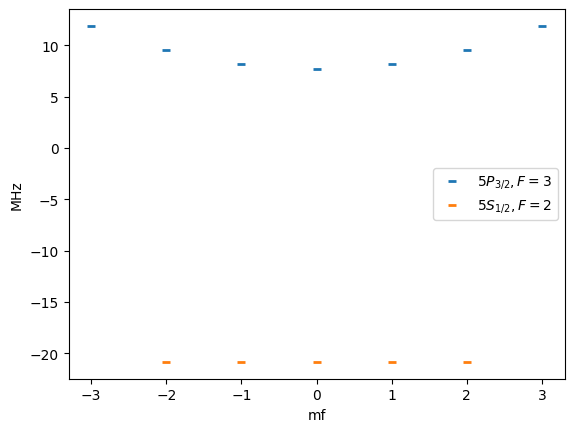

In [4]:
# quantum network experiment, circa Sept. 2023
rb = Rubidium87()
nlist = range(4,20)
omega = 2*pi*c/852e-9
TFORT = 1e-3

# state g = 5S1/2,f=2
n=5; l=0; j=1/2; f=2; mf=0;
a05S = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) #alpha_0
E = sqrt(4*kB*TFORT/a05S) # get field from ground state shift, which defines trap depth
w0 = 7.5e-7
I0 = 0.5*e0*c*E**2
P = 0.5*I0*pi*w0**2
print(f"dipole trap power {P*1e3:.2f}mW for waist {w0*1e6:.2f}um")
mfg_list = arange(-f,f+1)
scalar_g = [-(1/4)*a05S*E**2/(hbar*1e6*2*pi) for mf in mfg_list]

# state e = 5P3/2,f=3
n=5; l=1; j=3/2; f=3;
a05P = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)  
a25P = alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)

mfe_list = [mf for mf in arange(-f,f+1)]
tensor_e = [-1/4*( a05P + (3*mf**2-f*(f+1))/(1*f*(2*f-1))*a25P)*E**2/hbar/1e6/2/pi for mf in mfe_list]

mean_diff_shift_MHz = np.mean(tensor_e) - np.mean(scalar_g)
print(f"mean differential shift = {mean_diff_shift_MHz:.2f}MHz blue of 5S1/2,F=2 - 5P3/2,F=3")

fig, ax = plt.subplots()
ax.scatter(mfe_list, tensor_e, marker='_',linewidths=2,label=r'$5P_{3/2},F=3$')
ax.scatter(mfg_list, scalar_g, marker='_',linewidths=2,label=r'$5S_{1/2},F=2$')
# ax.set_ylim(-25,20)
ax.set_ylabel('MHz')
ax.set_xlabel('mf')
ax.legend()
plt.show()

dipole trap power 2.30mW for waist 0.75um
mean differential shift = 30.56MHz blue of 5S1/2,F=2 - 5P3/2,F=3


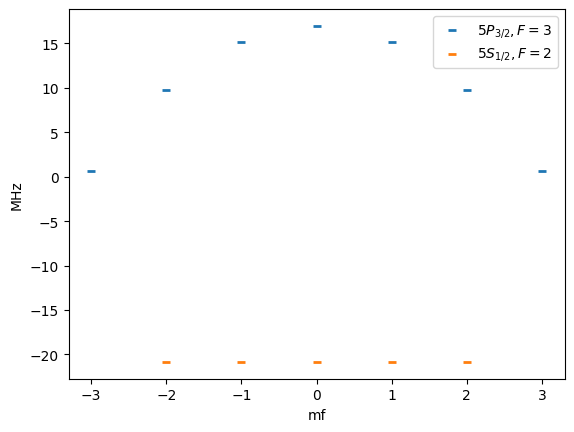

In [34]:
# we don't know exactly how much 852 power couples into the fiber, so let's say it's 50% +30%/-20%
rb = Rubidium87()
nlist = range(4,20)
omega = 2*pi*c/852e-9
TFORT = 1e-3

# state g = 5S1/2,f=2
n=5; l=0; j=1/2; f=2; mf=0;
a05S = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) #alpha_0

E = sqrt(4*kB*TFORT/a05S) # get field from ground state shift, which defines trap depth
w0 = 7.5e-7
I0 = 0.5*e0*c*E**2
P = 0.5*I0*pi*w0**2
print(f"dipole trap power {P*1e3:.2f}mW for waist {w0*1e6:.2f}um")
mfg_list = arange(-f,f+1)
scalar_g = [-(1/4)*a05S*E**2/(hbar*1e6*2*pi) for mf in mfg_list]

# state e = 5P3/2,f=3
n=5; l=1; j=3/2; f=3;
a05P = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)  
a25P = alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)

mfe_list = [mf for mf in arange(-f,f+1)]
tensor_e = [-1/4*( a05P + (3*mf**2-f*(f+1))/(1*f*(2*f-1))*a25P)*E**2/hbar/1e6/2/pi for mf in mfe_list]

mean_diff_shift_MHz = np.mean(tensor_e) - np.mean(scalar_g)
print(f"mean differential shift = {mean_diff_shift_MHz:.2f}MHz blue of 5S1/2,F=2 - 5P3/2,F=3")

fig, ax = plt.subplots()
ax.scatter(mfe_list, tensor_e, marker='_',linewidths=2,label=r'$5P_{3/2},F=3$')
ax.scatter(mfg_list, scalar_g, marker='_',linewidths=2,label=r'$5S_{1/2},F=2$')
# ax.set_ylim(-25,20)
ax.set_ylabel('MHz')
ax.set_xlabel('mf')
ax.legend()
plt.show()

## misc Rb 

In [112]:
# atom
rb = Rubidium87()

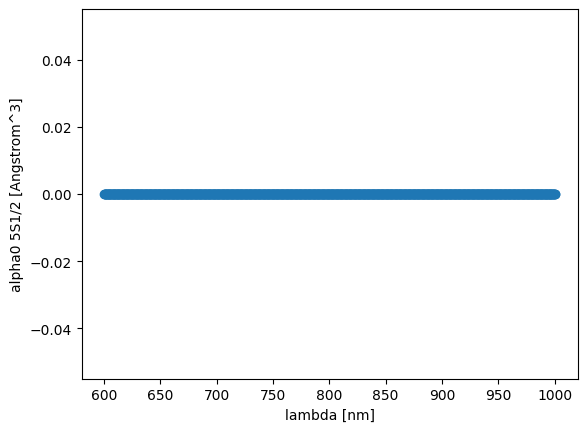

In [132]:
# 5S1/2,f=0
n=5; l=0; j=1/2; f=1; mf=0;

nlist = range(4,50)
a0 = lambda l: alpha0_hf([n,l,j,f], (2*pi*c/l*1e-9), nlist, atom=rb, I=I)
lambda_arr,a0_pts = smart_pts(a0,[600,1000],default_res=1000,alpha=2,dx_test=0.00001)

fig, ax = plt.subplots()
ax.scatter(lambda_arr,a0_pts/(4*pi*e0*1e-30))
# ax.set_ylim((-6000,6000))
ax.set_ylabel("alpha0 5S1/2 [Angstrom^3]")
ax.set_xlabel("lambda [nm]")
plt.show()

In [133]:
len(lambda_arr)

1002

In [1]:
## polarizability plot

nlist = range(4,50)
omega_list = [2*pi*c/(l*1e-9) for l in linspace(800,1000,300)]

# 5S1/2,f=1
n=5; l=0; j=1/2; f=1; mf=0;
a05Spts = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_0

NameError: name 'linspace' is not defined

In [2]:
fig, ax = plt.subplots()
lambda_arr = array([2*pi*c/omega for omega in omega_list])
ax.plot(lambda_arr/1e-9,array(a05Spts)/(4*pi*e0*1e-30))
#ax.set_ylim((-200,200))
plt.show()

NameError: name 'plt' is not defined

In [34]:
## polarizability plot

nlist = range(5,50)
omega_list = [2*pi*c/(l*1e-9) for l in linspace(800,1000,300)]

# 5P3/2,f=0
n=5; l=1; j=3/2; f=0; mf=0;
a05Spts = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list]

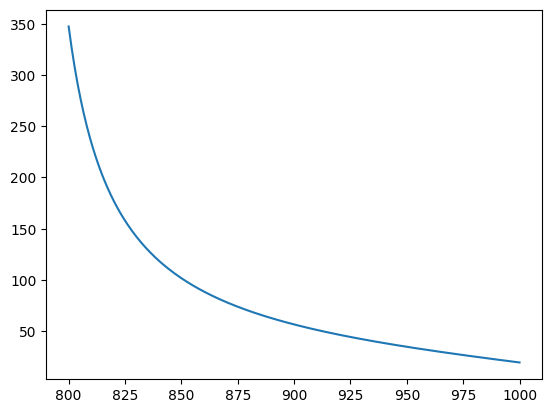

In [35]:
fig, ax = plt.subplots()
lambda_arr = array([2*pi*c/omega for omega in omega_list])
ax.plot(lambda_arr/1e-9,array(a05Spts)/(4*pi*e0*1e-30))
# ax.set_ylim((-300,300))
plt.show()

In [37]:
## polarizability plot

nlist = range(5,50)
omega_list = [2*pi*c/(l*1e-9) for l in linspace(800,1000,300)]

# 5S1/2,f=1
n=5; l=0; j=1/2; f=1; mf=0;
a05Spts1 = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_0

# 5P3/2,f=0
n=5; l=1; j=3/2; f=0; mf=0;
a05Spts2 = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list]

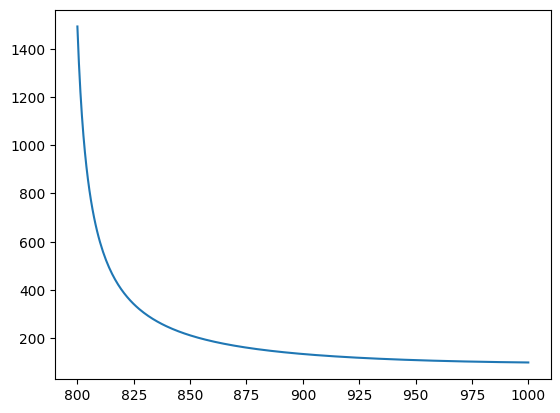

In [38]:
fig, ax = plt.subplots()
lambda_arr = array([2*pi*c/omega for omega in omega_list])
ax.plot(lambda_arr/1e-9,array(a05Spts1)/(4*pi*e0*1e-30)-array(a05Spts2)/(4*pi*e0*1e-30))
# ax.set_ylim((-300,300))
plt.show()

In [4]:
## polarizability plot 5S1/2,f=1 to 5P1/2,f=1

nlist = range(4,9)
omega_list = [2*pi*c/(l*1e-9) for l in linspace(852,900,100)] # rad/s

# 5S1/2,f=1
n=5; l=0; j=1/2; f=1; mf=1;
a05S0 = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_0
a05S2 = [alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_2
a05St = a05S0 + multiply(2*(3*mf**2-f*(f+1))/(2*f*(2*f-1)),a05S2)
# 5P1/2,f=1
n=5; l=1; j=1/2; f=1; mf=0;
a05P0 = [alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_0
a05P2 = [alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I) for omega in omega_list] #alpha_2
a05Pt = a05S0 + multiply(2*(3*mf**2-f*(f+1))/(2*f*(2*f-1)),a05S2)

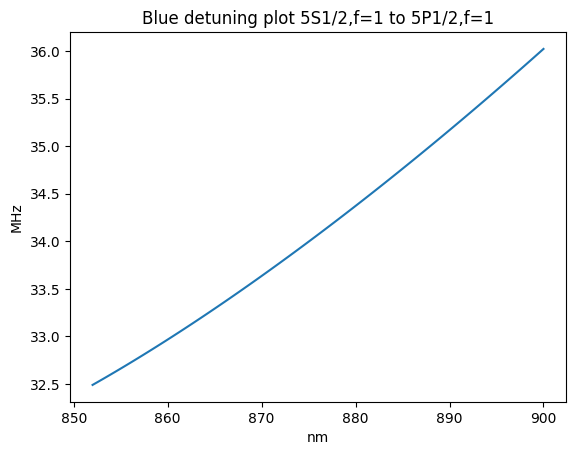

The minimum blue detuning is 32.489008205670984 MHz at a dipole trap frequency 351.8690821596244 THz, wavelength 852.0 nm
The powe of dipole trap should be 24.94542175488668 mW
Preparation of Bell states has a blue detuning of 90.51058754469986 MHz


In [5]:
w0 = 1.65e-6
Ufort = kB*1e-3
P_list = sqrt(divide(4*Ufort*e0*c*pi*w0**2/2,a05S0))
E_list = sqrt(divide(4*Ufort,a05S0))
energydiff = multiply(-1/4,multiply(a05P0-a05Pt,E_list**2))
enefreq = energydiff/(hbar*2*pi)/1e6
lambda_arr = array([2*pi*c/omega for omega in omega_list]) # in Hz
fig, ax = plt.subplots()
ax.plot(lambda_arr/1e-9, array(enefreq))
ax.set_xlabel('nm')
ax.set_ylabel('MHz')
ax.set_title('Blue detuning plot 5S1/2,f=1 to 5P1/2,f=1')
plt.show()
minenergy = min(enefreq)
minwave = lambda_arr[argmin(enefreq)] # in Hz
omega = omega_list[argmin(enefreq)] #rad/s
# 5S1/2,f=1
n=5; l=0; j=1/2; f=1; mf=0;
a05S0fix = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I) #alpha_0
# 5P3/2,f=0
n=5; l=1; j=3/2; f=0; mf=0;
a05P0fix = alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)  #alpha_0
E_fix = sqrt(4*Ufort/abs(a05P0fix))
P_fix = 4*Ufort*e0*c*pi*w0**2/2/a05S0fix
detun = -1/4*(a05P0fix-a05S0fix)*E_fix**2/(hbar*2*pi)/1e6
print('The minimum blue detuning is',minenergy,'MHz at a dipole trap frequency',c/minwave/1e12,'THz, wavelength',minwave/1e-9,'nm')
print('The powe of dipole trap should be',P_fix*1000,'mW')
print('Preparation of Bell states has a blue detuning of',detun,'MHz')

In [4]:
omega = 2*pi*c/(7.7e-7)

print("  5S1/2,f=2,mf=0:")
nlist = range(5,12)
n=5; l=0; j=1/2; f=2; mf=0;
print(f"    scalar = {alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)}")
# vector is zero for mf=0
# tensor is zero for j<1

print("  5P3/2,f=3,mf=1:")
n=5; l=1; j=3/2; f=3; mf=1; A = 1;
print(f"    scalar = {alpha0_hf([n,l,j,f], omega, nlist, atom=rb, I=I)}")
print(f"    vector = {A*mf*alpha1_hf([n,l,j,f], omega, nlist, atom=rb, I=I)/(2*f)}")
print(f"    tensor = {-1*((3*mf**2 - f*(f+1))/(2*f*(2*f-1)))*alpha2_hf([n,l,j,f], omega, nlist, atom=rb, I=I)}")

  5S1/2,f=2,mf=0:
    scalar = -3.863073734163827e-75
  5P3/2,f=3,mf=1:
    scalar = 1.1426236852848684e-75
    vector = -1.7730550494904606e-38
    tensor = -4.646776330746171e-76


## Polarizabilities for Rydberg addressing

In [5]:
# atom
rb = Rubidium87()

# lasers
omega780A = 2*pi*(hf_states[5][1][3/2][3] - hf_states[5][0][1/2][2] - 2.1)*1e9
omega780B = 2*pi*(hf_states[5][1][3/2][3] - hf_states[5][0][1/2][2] - 2.1 + 6.834682)*1e9
omega480 = 2*pi*(eVToGHz(rb.getEnergy(84,2,5/2) - rb.getEnergy(5,1,3/2)) - .266651 + 2.1)*1e9

In [57]:
print("Laser frequencies")
print(f" 780A: 2*pi*{omega780A/(2*pi)}")
print(f" 780B: 2*pi*{omega780B/(2*pi)}")
print(f" 480: 2*pi*{omega480/(2*pi)}")

print("780A polarizabilities")

nlist = range(5,8)

print("  5S1/2,f=2,mf=0:")
n=5; l=0; j=1/2; f=2; mf=0;
print(f"    scalar = {alpha0_hf([n,l,j,f], omega780A, nlist, atom=rb, I=I)}")
# vector is zero for mf=0
# tensor is zero for j<1

print("  5P3/2,f=3,mf=1:")
n=5; l=1; j=3/2; f=3; mf=1; A = 1;
print(f"    scalar = {alpha0_hf([n,l,j,f], omega780A, nlist, atom=rb, I=I)}")
print(f"    vector = {A*mf*alpha1_hf([n,l,j,f], omega780A, nlist, atom=rb, I=I)/(2*f)}")
print(f"    tensor = {-1*((3*mf**2 - f*(f+1))/(2*f*(2*f-1)))*alpha2_hf([n,l,j,f], omega780A, nlist, atom=rb, I=I)}")

print("480 polarizabilities")

print("  5S1/2,f=2,mf=0:")
n=5; l=0; j=1/2; f=2; mf=0;
nmax = 100; nmin = 5;
nlist = [int(x) for x in linspace(nmax,nmin,nmax-nmin+1)]
print(f"    scalar = {alpha0_hf([n,l,j,f], omega480, nlist, atom=rb, I=I)}")
# vector is zero for mf=0
# tensor is zero for j<1

print("  5P3/2,f=3,mf=1:")
n=5; l=1; j=3/2; f=3; mf=1; A = 1;
print(f"    scalar = {alpha0_hf([n,l,j,f], omega480, nlist, atom=rb, I=I)}")
print(f"    vector = {-A*mf*alpha1_hf([n,l,j,f], omega480, nlist, atom=rb, I=I)/(2*f)}") # overall minus sign because dot(k,B_bias)=
print(f"    tensor = {-1*((3*mf**2 - f*(f+1))/(2*f*(2*f-1)))*alpha2_hf([n,l,j,f], omega480, nlist, atom=rb, I=I)}")

Laser frequencies
 780A: 2*pi*384226015203379.4
 780B: 2*pi*384232849885379.44
 480: 2*pi*625314831618150.4
780A polarizabilities
  5S1/2,f=2,mf=0:
    scalar = 3.20346392953120E-34
  5P3/2,f=3,mf=1:
    scalar = 1.52739309640219E-34
    vector = -3.817491143122172e-35
    tensor = -4.581457685120631e-35
480 polarizabilities
  5S1/2,f=2,mf=0:
    scalar = -2.90311524481040E-39
  5P3/2,f=3,mf=1:
    scalar = -4.82150951678205E-39
    vector = 1.696626924053701e-40
    tensor = 4.557481703934684e-40


In [54]:
alpha780excited = scalar = 1.52739309640219E-34 + -3.817491143122172e-35 + -4.581457685120631e-35
alpha780excited

6.874982135779098e-35

In [60]:
alpha480excited = 3.53496801131378E-39 + 4.27727148997324e-40 + -7.310403832277205e-40
alpha480excited

3.231654777083384e-39

In [6]:
## ponderomotive shifts, S.I. units

alphaPond = lambda omega: -ee**2/(me*omega**2)

In [7]:
alphaPond(omega780A)

-4.8350228219114005e-39

In [8]:
alphaPond(omega480)

-1.825469589864302e-39

## Ramsey frequency
Clock state Ramsey experiment with 780A on in gap time gives a fringe frequency equal to the differential AC Stark shift from the 780A plus the differential Zeeman shift. The latter is 4 kHz at 3 G. This can be used to determine the electric field that the atom sees. We can also estimate the Rabi frequency directly.

In [10]:
rb = Rubidium87()

# lasers
omega780A = 2*pi*(hf_states[5][1][3/2][3] - hf_states[5][0][1/2][2] - 2.1)*1e9

# clock states differential AC stark shift = ramsey frequency - Zeeman shift
dU_ac = 2*pi*hbar*(1.34e6 - 4e3)

nlist = range(5,8)
efield = 2*sqrt(dU_ac/(alpha0_hf([5,0,1/2,2],omega780A,nlist,atom=rb,I=I)-alpha0_hf([5,0,1/2,1],omega780A,nlist,atom=rb,I=I)))
efield

3797.8949279380545

In [12]:
2*pi*c/omega780A

7.80250285346538e-07

In [13]:
2*pi*c/omega480

4.794264310414898e-07

In [22]:
2*pi*(hf_states[5][1][3/2][3] - hf_states[5][0][1/2][2])*1e9

2414176448051179.0

In [23]:
2*pi*(eVToGHz(rb.getEnergy(84,2,5/2) - rb.getEnergy(5,1,3/2)) - .266651)*1e9

3928955767695494.5